# Building Recommendation system using Python

In [1]:
# Importing the Required libraries 
import pandas as pd
import numpy as np
import os
import sys
import re
from datetime import datetime
# Importing the required packages for plotting graphs
import matplotlib.pyplot as plt
import seaborn as sns
# Importing libraries for model building and standardization
from sklearn import preprocessing
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import sklearn.metrics as metrics
from collections import Counter
from sklearn.neighbors import NearestNeighbors

In [2]:
# Setting global options for the notebook such as maxrows
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', None)
pd.set_option("display.max_rows", 100)
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Importing the Dataset 
path=os.getcwd()
# Assigning a path for the file 
ratings_path=path+"\\ratings.csv"
movies_path=path+"\\movies.csv"

In [4]:
# Loading the source file into Pandas DataFrame
ratings_df=pd.read_csv(ratings_path)
# Printing the shape of the dataframe
ratings_df.shape

(100836, 4)

In [5]:
# Loading the source file into Pandas DataFrame
movies_df=pd.read_csv(movies_path)
# Printing the shape of the dataframe
movies_df.shape

(9742, 3)

In [6]:
# Printing top 5 rows from ratings dataframe
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [7]:
# Printing top 5 rows from movies dataframe
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
# Joining the Ratings and Movies dataframe
merged_df1=ratings_df.merge(movies_df,on='movieId', how='left')

In [9]:
# Printing top few rows of merged dataframe
merged_df1.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


### EDA and Feature Engineering

In [10]:
# Calculating the number of ratings, number of movies and users
num_ratings = len(ratings_df)
num_movies = ratings_df['movieId'].nunique()
num_users = ratings_df['userId'].nunique()
# Printing the results
print(f"Number of ratings: {num_ratings}")
print(f"Number of unique movies: {num_movies}")
print(f"Number of unique users: {num_users}")
print(f"Average number of ratings per user: {round(num_ratings/num_users, 2)}")
print(f"Average number of ratings per movie: {round(num_ratings/num_movies, 2)}")

Number of ratings: 100836
Number of unique movies: 9724
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


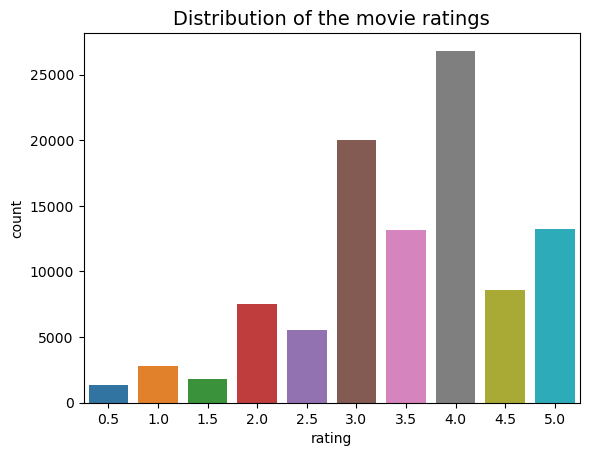

In [11]:
# Platting the results of Ratings as a Histogram
sns.countplot(x="rating",data=ratings_df)
plt.title("Distribution of the movie ratings", fontsize=14)
plt.show()

In [12]:
# Printing the Mean rating of all movies
print(f"Mean rating: {round(ratings_df['rating'].mean(),2)}")

Mean rating: 3.5


In [13]:
# Calculating the mean ratings per user
mean_ratings = ratings_df.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}")

Mean rating per user: 3.66


In [14]:
# Joining the ratings and movies dataframe using inner join
movie_ratings=ratings_df.merge(movies_df,on="movieId")
# Printing the list of movies with higher number of reviews
movie_ratings['title'].value_counts()[0:10]

Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            224
Schindler's List (1993)                      220
Name: title, dtype: int64

In [15]:
# Calculating the mean ratings for each movie
mean_movie_ratings=ratings_df.groupby('movieId').mean()[['rating']]

In [16]:
# Getting the lowest rated movie
lowest_rated=mean_movie_ratings['rating'].idxmin()
# Printing the name of the movie with lowest rating
movies_df[movies_df["movieId"]==lowest_rated]

,movieId,title,genres
2689,3604,Gypsy (1962),Musical


In [17]:
# Getting the lowest rated movie
highest_rated=mean_movie_ratings['rating'].idxmax()
# Printing the name of the movie with highest rating
movies_df[movies_df["movieId"]==highest_rated]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


In [18]:
# Grouping the ratings datfarme by movies and get the count and mean of ratings
movie_stats=ratings_df.groupby('movieId')['rating'].agg(['count','mean'])
movie_stats.head()

,count,mean
movieId,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429


In [19]:
# Finding the mean value of ratings for each movie
cnt=movie_stats['count'].mean()
# Finding the average ratings for each movie
mean=movie_stats['mean'].mean()
print(f"Average number of ratings for a given movie: {cnt:.2f}")
print(f"Average rating for a given movie: {mean:.2f}")
# Calculating the average using Bayesian average method using weights
def bayesian_avg(ratings):
    bayesian_avg = (cnt*mean+ratings.sum())/(cnt+ratings.count())
    return round(bayesian_avg, 3)

Average number of ratings for a given movie: 10.37
Average rating for a given movie: 3.26


In [20]:
# Applying the Bayesian average function on all the movies in the ratings dataset
bayesian_avg_ratings = ratings_df.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
# Rennaming the columns in the bayesian_avg_ratings dataframe
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
# Joining bayesian_avg_ratings and movie stats dataframe
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

In [21]:
# Joining the movie_stats dataframe with movies dataframe based on movieid and title
movie_stats = movie_stats.merge(movies_df[['movieId', 'title']])
# Sorting the results to find the most popular movie
movie_stats.sort_values('bayesian_avg', ascending=False).head()

,movieId,count,mean,bayesian_avg,title
277,318,317,4.429022,4.392,"Shawshank Redemption, The (1994)"
659,858,192,4.289062,4.236,"Godfather, The (1972)"
2224,2959,218,4.272936,4.227,Fight Club (1999)
224,260,251,4.231076,4.193,Star Wars: Episode IV - A New Hope (1977)
46,50,204,4.237745,4.191,"Usual Suspects, The (1995)"


In [22]:
# Sorting the results to find the least popular movies
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,movieId,count,mean,bayesian_avg,title
1172,1556,19,1.605263,2.190,Speed 2: Cruise Control (1997)
2679,3593,19,1.657895,2.224,Battlefield Earth (2000)
1372,1882,33,1.954545,2.267,Godzilla (1998)
1144,1499,27,1.925926,2.297,Anaconda (1997)
1988,2643,16,1.687500,2.307,Superman IV: The Quest for Peace (1987)


In [23]:
#  Formatting the genres in the movies dataset by extracting the values split by pipes into a list
movies_df['genres'] = movies_df['genres'].apply(lambda x: x.split("|"))
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [24]:
# Using collections to get the count of genre in the dataset 
genre_frequency = Counter(g for genres in movies_df['genres'] for g in genres)
# Printing the total number of genres
print(f"There are {len(genre_frequency)} genres.")
# Printing all the genres with the frequency in the dataset
genre_frequency

There are 20 genres.


Counter({'Adventure': 1263,
         'Animation': 611,
         'Children': 664,
         'Comedy': 3756,
         'Fantasy': 779,
         'Romance': 1596,
         'Drama': 4361,
         'Action': 1828,
         'Crime': 1199,
         'Thriller': 1894,
         'Horror': 978,
         'Mystery': 573,
         'Sci-Fi': 980,
         'War': 382,
         'Musical': 334,
         'Documentary': 440,
         'IMAX': 158,
         'Western': 167,
         'Film-Noir': 87,
         '(no genres listed)': 34})

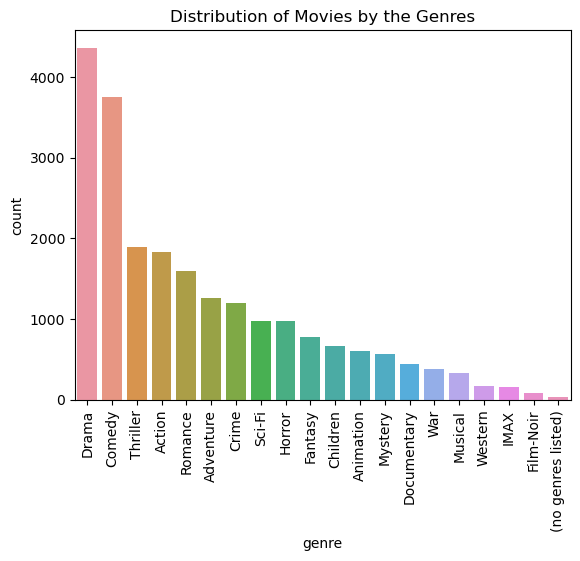

In [25]:
# Creating a dataframe with genre name and its frequency
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ['genre', 'count']
# Creating bar plot to illustrate the distribution of genre and its counts in the dataset.
sns.barplot(x='genre', y='count', data=genre_frequency_df.sort_values(by='count', ascending=False))
plt.xticks(rotation=90)
plt.title("Distribution of Movies by the Genres")
plt.show()

### Recommendation system: Approach 1 using Correlation Method

In [26]:
# Finding the average rating of each movie in the Dataset
avg_ratings=pd.DataFrame(merged_df1.groupby('title').mean()['rating'])
# Adding a new column named count ratings
avg_ratings['count_ratings']=pd.DataFrame(merged_df1.groupby('title').count()['rating'])
avg_ratings.head()

,rating,count_ratings
title,,
'71 (2014),4.0,1
'Hellboy': The Seeds of Creation (2004),4.0,1
'Round Midnight (1986),3.5,2
'Salem's Lot (2004),5.0,1
'Til There Was You (1997),4.0,2


In [27]:
# Using pivot table function to reshape the dataframe
pivot_df=merged_df1.pivot_table(index='userId',columns='title',values='rating')
pivot_df.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...And Justice for All (1979),00 Schneider - Jagd auf Nihil Baxter (1994),1-900 (06) (1994),10 (1979),10 Cent Pistol (2015),10 Cloverfield Lane (2016),10 Items or Less (2006),10 Things I Hate About You (1999),10 Years (2011),"10,000 BC (2008)",100 Girls (2000),100 Streets (2016),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),...,Zipper (2015),Zodiac (2007),Zombeavers (2014),Zombie (a.k.a. Zombie 2: The Dead Are Among Us) (Zombi 2) (1979),Zombie Strippers! (2008),Zombieland (2009),Zone 39 (1997),"Zone, The (La Zona) (2007)",Zookeeper (2011),Zoolander (2001),Zoolander 2 (2016),Zoom (2006),Zoom (2015),Zootopia (2016),Zulu (1964),Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
# Calculating pairwise correlation using corrwith function and calculating results for "The shining"
corr_results=pivot_df.corrwith(pivot_df['Shining, The (1980)'])
corr_results

title
'71 (2014)                                        NaN
'Hellboy': The Seeds of Creation (2004)           NaN
'Round Midnight (1986)                            NaN
'Salem's Lot (2004)                               NaN
'Til There Was You (1997)                         NaN
                                               ...   
eXistenZ (1999)                             -0.504770
xXx (2002)                                   0.058187
xXx: State of the Union (2005)              -0.190693
¡Three Amigos! (1986)                        0.118727
À nous la liberté (Freedom for Us) (1931)         NaN
Length: 9719, dtype: float64

In [29]:
# Calculating the recommendations and cleansing it by dropping nulls
recommendation = pd.DataFrame(corr_results,columns=['Correlation'])
recommendation.dropna(inplace=True)
# The recommendation results are then joined with average ratings
recommendation = recommendation.join(avg_ratings['count_ratings'])
recommendation.head()

,Correlation,count_ratings
title,,
"'burbs, The (1989)",0.476152,17
(500) Days of Summer (2009),0.239143,42
*batteries not included (1987),0.870388,7
...And Justice for All (1979),-1.000000,3
10 Cloverfield Lane (2016),0.184289,14


In [30]:
# The resulting dataframe with the count of reviews more then 100 with higher correlation are extracted
recc = recommendation[recommendation['count_ratings']>100].sort_values('Correlation',ascending=False).reset_index()
# The results are joined with movies dataframe to get the movie titles and genre
final_recommendation = recc.merge(movies_df,on='title', how='left')
final_recommendation.head(10)

,title,Correlation,count_ratings,movieId,genres
0,"Shining, The (1980)",1.000000,109,1258,[Horror]
1,Waterworld (1995),0.515491,115,208,"[Action, Adventure, Sci-Fi]"
2,Léon: The Professional (a.k.a. The Professional) (Léon) (1994),0.515057,133,293,"[Action, Crime, Drama, Thriller]"
3,Donnie Darko (2001),0.468267,109,4878,"[Drama, Mystery, Sci-Fi, Thriller]"
4,Outbreak (1995),0.459459,101,292,"[Action, Drama, Sci-Fi, Thriller]"
5,Crimson Tide (1995),0.445512,103,161,"[Drama, Thriller, War]"
6,Trainspotting (1996),0.411779,102,778,"[Comedy, Crime, Drama]"
7,"Breakfast Club, The (1985)",0.391780,113,1968,"[Comedy, Drama]"
8,Braveheart (1995),0.370874,237,110,"[Action, Drama, War]"
9,Stargate (1994),0.365455,140,316,"[Action, Adventure, Sci-Fi]"


### Recommendation system: Approach 2 using Sparse Matrix and KNN method

In [31]:
# imporing csr_matrix to create sparse matrix
from scipy.sparse import csr_matrix
# Getting the list of unique elements in the User id and movie id of ratings dataframe
user_count = ratings_df['userId'].nunique()
movie_count = ratings_df['movieId'].nunique()
# Creating User mapper, movie mapper and the inverse mappers using zip and dict functions
user_mapper = dict(zip(np.unique(ratings_df["userId"]), list(range(user_count))))
movie_mapper = dict(zip(np.unique(ratings_df["movieId"]), list(range(movie_count))))
user_inv_mapper = dict(zip(list(range(user_count)), np.unique(ratings_df["userId"])))
movie_inv_mapper = dict(zip(list(range(movie_count)), np.unique(ratings_df["movieId"])))
# Extracting the row and column index to be used for sparse matric
user_index = [user_mapper[i] for i in ratings_df['userId']]
item_index = [movie_mapper[i] for i in ratings_df['movieId']]
# Creating sparse matrix using csr_matrix from rating data and shape , row and column index are also provided
sparse_matrix = csr_matrix((ratings_df["rating"], (user_index,item_index)), shape=(user_count,movie_count))

In [32]:
# Printing the shape of sparse matrix
sparse_matrix.shape

(610, 9724)

In [33]:
# Creating function to find movie recommendations
def find_movie_recommendations(movie_id, sparse_matrix, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given movie id.
    
    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations
    
    Output: returns list of k similar movie ID's
    """
    # Transposing the sparse matrix
    sparse_matrix = sparse_matrix.T
    # Creating empty list to capture the neighbor results
    neighbour_ids = []
    # Find the index of the movie of intesrest
    movie_ind = movie_mapper[movie_id]
    # Creating a vector of the ratings of the movie from the sparse matrix
    movie_vec = sparse_matrix[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
    # use k+1 since kNN output includes the movieId of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    # Fitting the KNN model for the sparse matrix data
    kNN.fit(sparse_matrix)
    # FInding the neighbors using the kneighbors method of KNN model
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    # Appending the results of neighbors to the neighbor_ids list
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    # Removing the first item of the list to exclude the movie being searched.
    neighbour_ids.pop(0)
    # Returning the movie ids of the nearest movies of interest.
    return neighbour_ids

In [35]:
# Testing the function using "The Shining"
movie_name='Shining, The (1980)'
# Creating dictionary of Movie Id and names
movie_ids = dict(zip(movies_df['title'],movies_df['movieId']))
# Extracting the movie id of the movie of interest
movie_id = movie_ids[movie_name]
# Finding similar movies using find_movie_recommendations function
similar_movies = find_movie_recommendations(movie_id, sparse_matrix, movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_titles = dict(zip(movies_df['movieId'],movies_df['title']))
# Printing the movie recommendations
print(f"Because you watched {movie_name}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Shining, The (1980):
Psycho (1960)
Clockwork Orange, A (1971)
Goodfellas (1990)
Alien (1979)
Sixth Sense, The (1999)
Reservoir Dogs (1992)
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)
Fight Club (1999)
Fargo (1996)
